# Классификация облаков

Решение задачи имеет смысл начинать с ее классификации.

У нас есть набор фотографий облачных скоплений, разметка по областям и классификация типов облаков. 
На одном изображении может быть несколько типов облаков, причем области разных типов могу пересекаться, быть фрагментированными, 
занимать разные по размеру области и иметь размытые границы.

Обученная сеть должна уметь выделять на фотографиях области в виде маски и классифицировать их типы.

По сути это задача семантической сегментации с несколькими классами (multi-class semantic segmentation).\
Семантическая сегментация - это тип сегментации классифицирует каждый пиксель изображения, но не различает разные экземпляры одного и того же объекта. Например, все автомобили на изображении будут отнесены к одной категории «автомобиль», без деления на отдельные экземпляры.

Оптимальный класс моделей по мнению ChatGPT: Encoder–Decoder архитектуры для семантической сегментации и конкретно U-Net / U-Net++ / DeepLabV3+.

Лучший практический выбор под эту задачу
DeepLabV3+ с предобученным энкодером (ResNet / EfficientNet)

Почему именно он:

* Облака - объекты разного масштаба от тонких перьев до огромных массивов. 
  DeepLab использует ASPP (Atrous Spatial Pyramid Pooling) - отлично ловит multi-scale контекст.
* Размытые границы. atrous-свёртки дают широкий receptive field. Модель видит «картину целиком», а не только локальные паттерны
* Хорошо работает на спутниковых данных.

#### Алгоритм решения

Несмотря на предложения ChatGPT по созданию современной модели, данную задачу буду решать в упрощенном виде, путем построения минимальной модели и обучения ее только на одном классе. \
Это связано исключительно с целю уменьшения вычислительной мощности и повышения наглядности.

In [1]:
# preload local libs
import sys
import os
import pathlib

project_dir = str(pathlib.Path(os.getcwd()).parent.resolve())
if project_dir not in sys.path:
    sys.path.insert(1, project_dir)

# project_dir

In [2]:
data_dir = '/HDD/usr/dionx/КУРСЫ/OTUS'
data_train_img_dir = data_dir + '/train_images'
data_test_img_dir = data_dir + '/test_images'
data_train_img_dir_resampled = data_dir + '/train_images/resampled'
data_train_csv = data_dir + '/train.csv'

In [4]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import models, datasets, transforms
from torchvision.transforms import functional as TF
from torch.utils.data import Dataset, DataLoader, random_split

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt
import cv2
import math
from tqdm import tqdm

import pandas as pd
import numpy as np

from PIL import Image
import random

NUM_WORKERS = 8
BATCH_SIZE = 32
SHAPE = (1400, 2100)
# RESIZED = (350, 525)
RESIZED = (128, 128)
#DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE = 'cuda'

Считываем метки

In [5]:
df = pd.read_csv(data_train_csv)
df[['Image', 'Class']] = df['Image_Label'].str.rsplit('_', n=1).tolist()

In [6]:
df

,Image_Label,EncodedPixels,Image,Class
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...,0011165.jpg,Fish
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...,0011165.jpg,Flower
2,0011165.jpg_Gravel,NaN,0011165.jpg,Gravel
3,0011165.jpg_Sugar,NaN,0011165.jpg,Sugar
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...,002be4f.jpg,Fish
...,...,...,...,...
22179,ffd6680.jpg_Sugar,NaN,ffd6680.jpg,Sugar
22180,ffea4f4.jpg_Fish,NaN,ffea4f4.jpg,Fish
22181,ffea4f4.jpg_Flower,1194860 675 1196260 675 1197660 675 1199060 67...,ffea4f4.jpg,Flower
22182,ffea4f4.jpg_Gravel,NaN,ffea4f4.jpg,Gravel


#### Метод декодирования RLE

In [7]:
def rle_decode(rle_string, shape=SHAPE):
    """
    Декодирует маску из RLE-формата (Run-Length Encoding) в 2D-массив.
    
    Параметры:
        encoded_pixels: строка с чередующимися стартовыми позициями и длинами (1-based)
        shape: tuple (height, width) — размер выходной маски
    
    Возвращает:
        np.ndarray формы shape с типом uint8 (1 — пиксель объекта, 0 — фон)
    """
    # Обработка NaN или пустых значений
    if isinstance(rle_string, float) and math.isnan(rle_string):
        return np.zeros(shape, dtype=np.uint8, order='F')
    
    if not rle_string or rle_string == '':  # пустая строка или None
        return np.zeros(shape, dtype=np.uint8, order='F')
    
    # Разбиваем строку на список чисел (как строки)
    parts = rle_string.split()
    
    # Преобразуем в массивы, используя np.asarray
    starts = np.asarray(parts[0::2], dtype=np.int64) - 1      # 1-based → 0-based
    lengths = np.asarray(parts[1::2], dtype=np.int64)
    
    # Создаём плоский массив нужного размера
    flat_mask = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    
    # Заполняем интервалы значением 1
    for start, end in zip(starts, starts + lengths):
        flat_mask[start:end] = 1
    
    # Возвращаем в нужной форме с Fortran-order (по столбцам), как в оригинале
    return flat_mask.reshape(shape, order='F')

#### Архитектура сети

    Input
    ↓
    Encoder (Conv blocks + Downsample)
    ↓
    Bottleneck
    ↓
    Decoder (Upsample + Skip + Conv blocks)
    ↓
    Output masks (4 × H × W, sigmoid)

#### Аугментация

In [8]:
# использоуется albumentations так как нужны синхронные преобразоания изображения с маской
train_transform = A.Compose([
        A.Resize(height=RESIZED[0], width=RESIZED[1]), # ресайз до фиксированного размера
        A.HorizontalFlip(p=0.5),                       # случайное горизонтальное отражение
        A.Rotate(limit=30, p=0.5, interpolation=cv2.INTER_NEAREST), # рандомно поворачиваем. interpolation для Dice
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # RGB # type: ignore
        # A.Normalize(mean=[0.5], std=[0.5]),            # нормализация для 1-канального grayscale # type: ignore
        ToTensorV2(),                                  # конвертация в тензор PyTorch
    ]
)
# Для тестовой выборки другой набор преобразований
test_transform = A.Compose([
        A.Resize(height=RESIZED[0], width=RESIZED[1]), # ресайз до фиксированного размера
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # RGB # type: ignore
        ToTensorV2(),                                  # конвертация в тензор PyTorch
    ]
)

#### DataSet и DataLoader

Разделим для наглядности на 4 разных класса. Это меняет тип задачи на классическую задачу семантической сегментации.

Была идея оставить в обучающей выборке только фотографии с непустой маской.\
Однако, такой вариант не был рекомендован 
из-за того, что сеть не научится определять фотографии, где нет искомого типа облаков. 

Таки образом:

In [9]:
df_fish = df[df['Class'] == 'Fish'].reset_index(drop=True)
df_flower = df[df['Class'] == 'Flower'].reset_index(drop=True)
df_gravel = df[df['Class'] == 'Gravel'].reset_index(drop=True)
df_sugar = df[df['Class'] == 'Sugar'].reset_index(drop=True)

Определяем CloudDataset, который будет получать на вход набор даных только одного из классов

In [10]:
class CloudDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # label: 0,1,2,3
        # label = self.class_to_idx[row['Class']]
        # image
        img_path = os.path.join(self.img_dir, row['Image'])
        image = np.array(Image.open(img_path).convert('RGB'))
        # mask.
        h, w, _ = image.shape
        mask = rle_decode(row['EncodedPixels'], (h, w))

        # synchronized transforms
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image'] # torch.Tensor [C,H,W]
            # albumentations сама определяет, какие преобразования не надо применять к маске.
            mask = augmented['mask']   # torch.Tensor [H,W]
        
        mask = mask.unsqueeze(0).float()  # [1,H,W]
        # label = torch.tensor(label, dtype=torch.long)

        return image, mask

In [11]:
df_fish_sample = df_fish.sample(frac=0.1, random_state=100)

fish_dataset = CloudDataset(
    df=df_fish_sample,
    img_dir=data_train_img_dir,
    transform=train_transform
)

In [12]:
# Sanity-check
image, mask = fish_dataset[2]

print("image:", image.shape, image.dtype)
print("image min/max:", image.min().item(), image.max().item())
print("mask :", mask.shape, mask.dtype)
print("mask min/max:", mask.min().item(), mask.max().item())

image: torch.Size([3, 128, 128]) torch.float32
image min/max: -2.1179039478302 2.587712287902832
mask : torch.Size([1, 128, 128]) torch.float32
mask min/max: 0.0 1.0


#### Пример картинок с масками из обучающей выборки

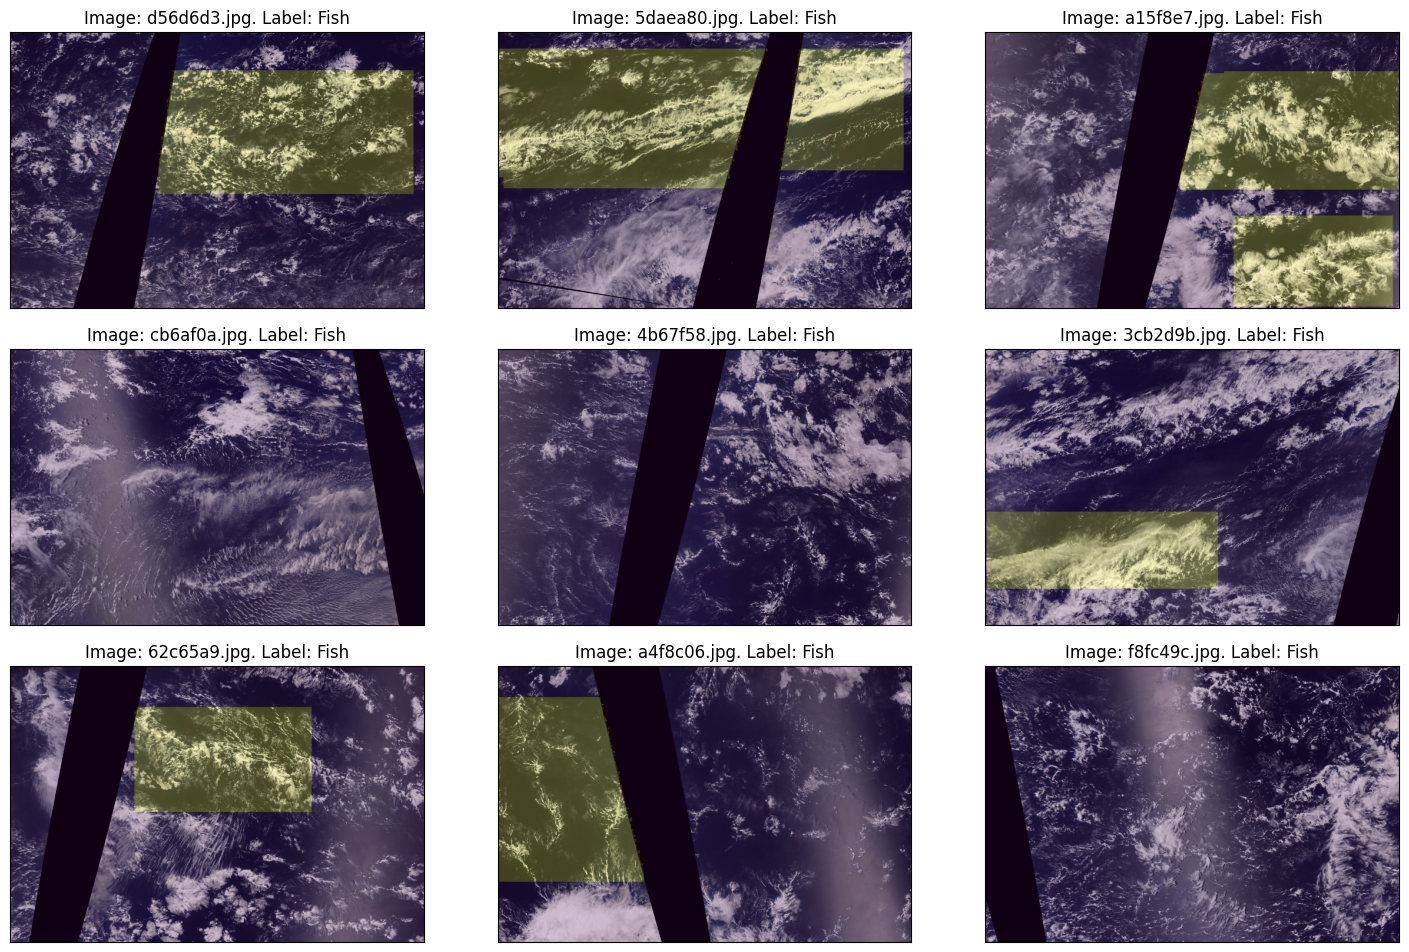

In [13]:
fig = plt.figure(figsize=(15, 10))
fig.subplots_adjust(
    left=0.02,    # минимальный левый отступ
    right=0.98,   # минимальный правый отступ
    bottom=0.02,  # минимальный нижний отступ
    top=0.93,     # оставляем место для заголовков сверху
    wspace=0.05,  # горизонтальное расстояние между субплотами
    hspace=0.15   # вертикальное расстояние (можно уменьшить до 0.1)
)

plt_idx = 1
for idx in random.sample(range(len(fish_dataset)), 9):
    row = fish_dataset.df.iloc[idx]
    image_name = row['Image']
    label = row['Class']
    img_path = os.path.join(fish_dataset.img_dir, row['Image'])
    ax = fig.add_subplot(3, 3, plt_idx, xticks=[], yticks=[])
    image = Image.open(img_path).convert('RGB')
    plt.imshow(image)
    mask = rle_decode(row['EncodedPixels'], (image.height, image.width))
    plt.imshow(mask, alpha=0.25)
    ax.set_title(f"Image: {image_name}. Label: {label}")
    plt_idx += 1

#### Делим выборку на тренировочную и тестовую

In [14]:
test_size = int(len(fish_dataset) * 0.2)
train_size = len(fish_dataset) - test_size

train_dataset, test_dataset = random_split(
    fish_dataset,
    [train_size, test_size],
    generator=torch.Generator().manual_seed(100)
)

# У валидационной не должно быть аугментации
test_dataset.dataset.transform = test_transform

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

#### Блоки нейросети

In [15]:
# Блок энкодера
class EncoderBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=False),  # 3 канала (RGB)
            # В EncoderBlock можно убрать bias=True перед BatchNorm (стандартная практика — bias поглощается BN).
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.block(x)
    
# Энкодер
class Encoder(nn.Module):
    def __init__(self, in_ch=3):
        super().__init__()

        self.enc1 = EncoderBlock(in_ch, 32)
        self.enc2 = EncoderBlock(32, 64)
        self.enc3 = EncoderBlock(64, 128)
        self.enc4 = EncoderBlock(128, 256)

        self.pool = nn.MaxPool2d(2) # Downsample

    def forward(self, x):
        x1 = self.enc1(x)          # H
        x2 = self.enc2(self.pool(x1))  # H/2
        x3 = self.enc3(self.pool(x2))  # H/4
        x4 = self.enc4(self.pool(x3))  # H/8

        return x1, x2, x3, x4

# Блок декодера
class DecoderBlock(nn.Module):
    def __init__(self, in_ch, skip_ch, out_ch):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False)
        self.conv = EncoderBlock(in_ch + skip_ch, out_ch)

    def forward(self, x, skip):
        x = self.up(x)
        x = torch.cat([x, skip], dim=1)
        return self.conv(x)
    
# Декодер
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.up4 = DecoderBlock(512, 256, 256)
        self.up3 = DecoderBlock(256, 128, 128)
        self.up2 = DecoderBlock(128, 64, 64)
        self.up1 = DecoderBlock(64, 32, 32)

    def forward(self, x5, x4, x3, x2, x1):
        d4 = self.up4(x5, x4)  # H/8
        d3 = self.up3(d4, x3)  # H/4
        d2 = self.up2(d3, x2)  # H/2
        d1 = self.up1(d2, x1)  # H

        return d1

#### CNN

In [16]:
# Собираем блоки в модель
class CustomUNet(nn.Module):
    def __init__(self, in_ch=3, num_classes=1): # один класс на элемент
        super().__init__()

        self.encoder = Encoder(in_ch)
        self.pool = nn.MaxPool2d(2)
        self.bottleneck = EncoderBlock(256, 512)
        self.decoder = Decoder()
        self.out = nn.Conv2d(32, num_classes, 1)

    def forward(self, x):
        # Энкодер
        x1, x2, x3, x4 = self.encoder(x)

        # Бутылочное горлышко
        # Можно добавить dropout в bottleneck для регуляризации (опционально).
        x5 = self.pool(x4)        # [B, 256, H/8, W/8]
        x5 = self.bottleneck(x5)  # [B, 512, H/8, W/8]

        # Декодер с skip-connections
        d = self.decoder(x5, x4, x3, x2, x1)

        logits = self.out(d)        # [B, 1, H, W]
        return logits               
    
        # Финальный вывод
        # self.out = nn.Conv2d(32, 1, 1)  # num_classes=1
        # return self.out(d)

#### Функция потерь

In [17]:
def dice_loss(logits: torch.Tensor,
              targets: torch.Tensor,
              smooth: float = 1.0) -> torch.Tensor:
    """
    Простой Dice Loss для бинарной сегментации.
    
    Args:
        logits (torch.Tensor): Сырой выход модели [B, 1, H, W] — до sigmoid
        targets (torch.Tensor): Истинная маска [B, 1, H, W] — значения 0.0 и 1.0
        smooth (float): сглаживание, чтобы не делить на ноль (обычно 1.0)
    
    Returns:
        torch.Tensor: скаляр — значение лосса (1 - Dice)
    """
    # Применяем sigmoid, чтобы получить вероятности от 0 до 1
    probs = torch.sigmoid(logits)

    # Вытягиваем тензоры в одномерные векторы
    probs = probs.view(-1)   # [B, N]
    targets = targets.view(-1)  # [B, N]

    # Считаем пересечение (intersection) и сумму (union)
    intersection = (probs * targets).sum()
    union = probs.sum() + targets.sum()
    # Dice коэффициент
    dice = (2 * intersection + smooth) / (union + smooth)

    # Лосс: чем ближе к 0, тем лучше
    return 1 - dice

#### Цикл обучения

В простом виде классический цикл обучения будет выглядеть таким образом:

In [18]:
model = CustomUNet(in_ch=3, num_classes=1) # RGB
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for images, masks in tqdm(train_loader):
    images = images.to(DEVICE)   # [B, 3, 256, 256]
    masks = masks.to(DEVICE)     # [B, 1, 256, 256] — float с 0 и 1
    
    # Forward
    out = model(images)      # [B, 1, 256, 256] — logits (без sigmoid!)
    # Вычисляем потери
    loss = dice_loss(out, masks)
    # Обнуляем градиенты параметров сети
    optimizer.zero_grad()
    # Обновляем градиенты параметров сети
    loss.backward()
    # Применяем градиенты к параметрам сети
    optimizer.step()

100%|██████████| 14/14 [00:13<00:00,  1.02it/s]


То есть у нас маска непрямую не участвует в обучении модели, а оказывает влияние только на функцию потерь, показывая модели, где она учится хорошо, а где не очень.
Так же она помогает модели понимать, на каких фото нет вообще искомого признака.

Теперь построим цикл обучения, в который добавим эпохи и этап валидации 

In [19]:
def train_model(
        _model,
        _data_loader,
        _criterion,
        _optimizer,
        _num_epochs=1
    ):
    # TRAIN
    _model.train()
    for epoch in range(_num_epochs):
        running_loss = 0.0
        batch_num = 0
        for images, masks in tqdm(_data_loader):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)
            out = _model(images)
            loss = _criterion(out, masks)
            _optimizer.zero_grad()
            loss.backward()
            _optimizer.step()
            running_loss += loss.item()
            batch_num += 1
            # print(f'    batch: {batch_num}, size: {len(images)}')
        print(f'Epoch {epoch+1}, Loss: {running_loss/len(_data_loader):.4f}')

Усредненная Dice-метрика

In [20]:
def evaluate_dice(_model, _test_loader):
    _model.eval()
    dices = []
    with torch.no_grad():
        for images, masks in tqdm(_test_loader):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)
            out = _model(images)
            dice = dice_loss(out, masks)
            dices.append(dice.item())
    return np.mean(dices), np.std(dices)

In [21]:
# Количество эпох
EPOCHS = 3

model = CustomUNet(in_ch=3, num_classes=1).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = dice_loss

train_model(model, train_loader, criterion, optimizer, EPOCHS)

mean_dice, std_dice = evaluate_dice(model, test_loader)
print(f"Mean Dice: {mean_dice:.4f} ± {std_dice:.4f}")

100%|██████████| 14/14 [00:04<00:00,  3.46it/s]


Epoch 1, Loss: 0.7074


100%|██████████| 14/14 [00:03<00:00,  3.99it/s]


Epoch 2, Loss: 0.6577


100%|██████████| 14/14 [00:03<00:00,  3.94it/s]


Epoch 3, Loss: 0.6236


100%|██████████| 4/4 [00:03<00:00,  1.20it/s]

Mean Dice: 0.6461 ± 0.0847


Удивительно. Слабенько, но все-таки модель обучается.

#### Инференс

In [22]:
sample_df = test_dataset.dataset.df
sample_row = sample_df.dropna().sample(1)
row = sample_row.iloc[0]
img_filename = row['Image']

img_path = os.path.join(data_train_img_dir, img_filename)
image = Image.open(img_path).convert('RGB')
mask = rle_decode(row['EncodedPixels'], (image.height, image.width))

# применяем тестовые трансформации
augmented = test_transform(image=np.array(image), mask=mask)
input_tensor = augmented['image'].unsqueeze(0).to(DEVICE)  # [B,3,H,W]

model.eval()
with torch.no_grad():
    logits = model(input_tensor)   # [1,1,H,W], logits
    prob_map = torch.sigmoid(logits)  # преобразуем логиты в вероятности
    pred_mask = (prob_map > 0.5).float()  # бинарная маска

    mask_np = pred_mask.squeeze(0).squeeze(0).cpu().numpy()  # [H,W]
    mask_heatmap = (prob_map.squeeze(0).squeeze(0) * 255).cpu().numpy().astype(np.uint8)
    color_mask = cv2.applyColorMap(mask_heatmap, cv2.COLORMAP_JET)

mask_np.sum()

np.float32(12291.0)

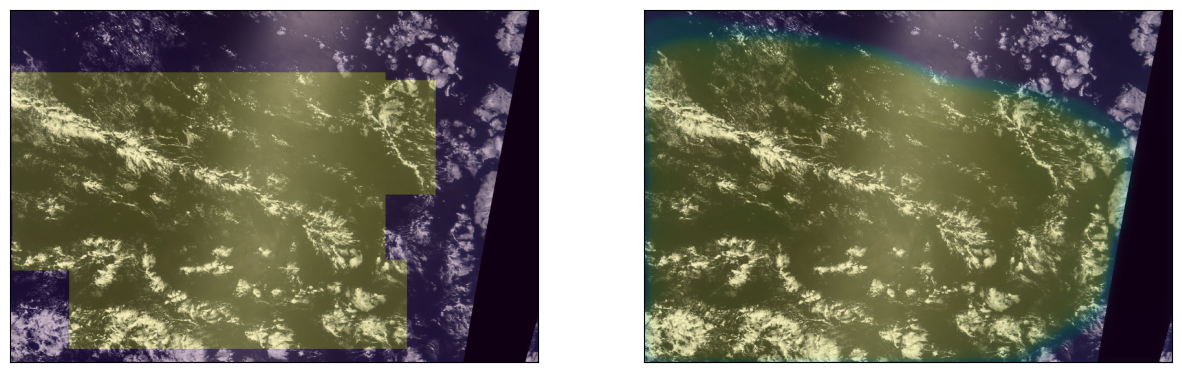

In [23]:
fig = plt.figure(figsize=(15, 10))

row = fish_dataset.df.iloc[idx]
image_name = row['Image']
label = row['Class']
img_path = os.path.join(fish_dataset.img_dir, row['Image'])

ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
plt.imshow(image)
plt.imshow(mask, alpha=0.25)

ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
# Увеличиваем предсказанную маску к размеру оригинала
# mask_resized = F.interpolate(
#     pred_mask, 
#     size=(image.height, image.width), 
#     mode='nearest'
# )

mask_heatmap_resized = cv2.resize(
    mask_heatmap,
    (image.width, image.height),
    interpolation=cv2.INTER_LINEAR
)
plt.imshow(image)
plt.imshow(mask_heatmap_resized, alpha=0.25)